<p><font size="6"><b> Case study: air quality data of European monitoring stations (AirBase)</b></font></p><br>
**AirBase (The European Air quality dataBase): hourly measurements of all air quality monitoring stations from Europe. **

> *DS Data manipulation, analysis and visualisation in Python*  
> *December, 2017*

> *© 2016, Joris Van den Bossche and Stijn Van Hoey  (<mailto:jorisvandenbossche@gmail.com>, <mailto:stijnvanhoey@gmail.com>). Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn

pd.options.display.max_rows = 8

/home/joris/miniconda3/envs/DS-python-data-analysis/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In the previous notebook, we processed some raw data files of the AirBase air quality data. As a reminder, the data contains hourly concentrations of nitrogen dioxide (NO2) for 4 different measurement stations:

- FR04037 (PARIS 13eme): urban background site at Square de Choisy
- FR04012 (Paris, Place Victor Basch): urban traffic site at Rue d'Alesia
- BETR802: urban traffic site in Antwerp, Belgium
- BETN029: rural background site in Houtem, Belgium

See http://www.eea.europa.eu/themes/air/interactive/no2

# Importing and quick exploration

We processed the individual data files in the previous notebook, and saved it to a csv file `airbase_data.csv`. Let's import the file here (if you didn't finish the previous notebook, a version of the dataset is also available in `../data/airbase_data.csv`):

In [2]:
alldata = pd.read_csv('airbase_data.csv', index_col=0, parse_dates=True)
alldata.index.name = 'datetime'

We only use the data from 1999 onwards:

In [3]:
data = alldata['1999':].copy()

Some first exploration with the *typical* functions:

In [4]:
data.head() # tail()

,BETR801,BETN029,FR04037,FR04012
datetime,,,,
1999-01-01 00:00:00,27.0,13.0,68.0,105.0
1999-01-01 01:00:00,33.0,15.0,70.0,116.0
1999-01-01 02:00:00,24.0,16.0,72.0,114.0
1999-01-01 03:00:00,26.0,18.0,72.0,91.0
1999-01-01 04:00:00,NaN,19.0,74.0,81.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122736 entries, 1999-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 4 columns):
BETN029    111989 non-null float64
FR04037    120384 non-null float64
BETR801    106628 non-null float64
FR04012    119448 non-null float64
dtypes: float64(4)
memory usage: 4.7 MB


In [6]:
data.describe(percentiles=[0.1, 0.5, 0.9])

,BETN029,FR04037,BETR801,FR04012
count,111989.00000,120384.000000,106628.000000,119448.000000
mean,16.42093,40.040005,46.728969,87.993261
std,12.31968,23.024347,21.708333,41.317684
min,1.00000,0.000000,1.000000,0.000000
10%,4.00000,14.000000,21.000000,37.000000
50%,12.00000,37.000000,45.000000,88.000000
90%,34.00000,70.000000,75.000000,139.000000
max,105.00000,256.000000,339.000000,358.000000


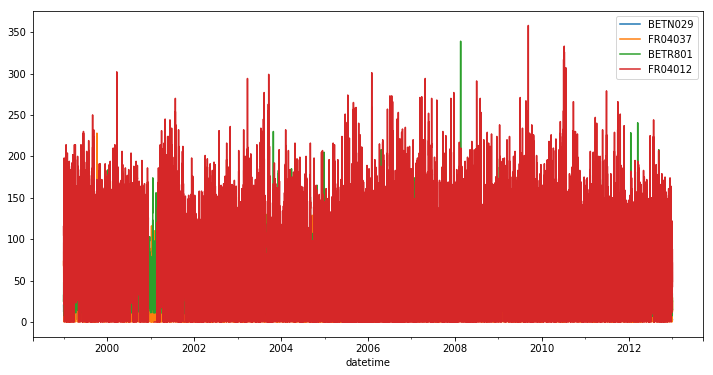

In [7]:
data.plot(figsize=(12,6))

<div class="alert alert-warning">
<b>ATTENTION!</b>: <br><br>

When just using `.plot()` without further notice (selection, aggregation,...)
 <ul>
  <li>Risk of running into troubles by overloading your computer processing (certainly with looooong time series)</li>
  <li>Not always the most informative/interpretable visualisation</li>
</ul>
</div>

**Plot only a subset**

Why not just using the `head`/`tail` possibilities?

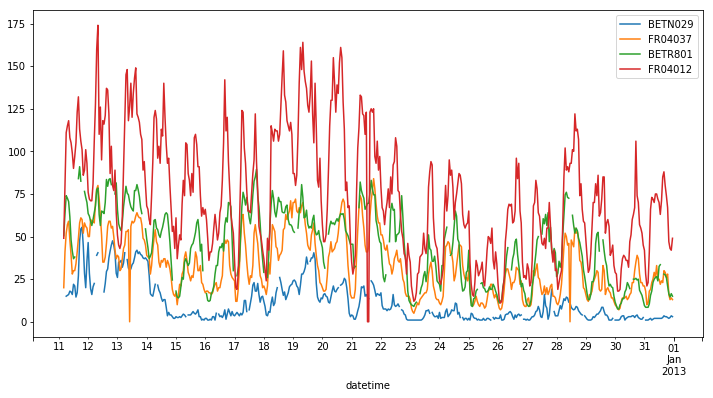

In [8]:
data.tail(500).plot(figsize=(12,6))

**Summary figures**

Use summary statistics...

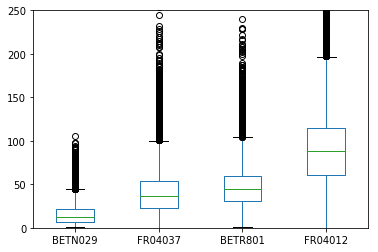

In [9]:
data.plot(kind='box', ylim=[0,250])

Also with seaborn plots function, just start with some subsets as first impression...

As we already have seen previously, the plotting library [seaborn](http://seaborn.pydata.org/generated/seaborn.heatmap.html) provides some high-level plotting functions on top of matplotlib (check the [docs](http://seaborn.pydata.org/examples/index.html)!). One of those functions is `pairplot`, which we can use here to quickly visualize the concentrations at the different stations and their relation:

In [10]:
import seaborn as sns

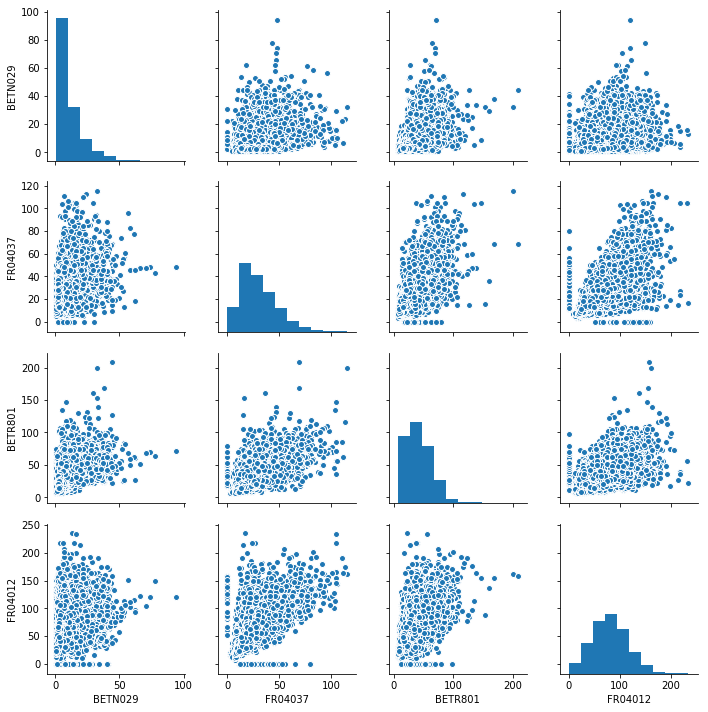

In [11]:
sns.pairplot(data.tail(5000).dropna())

# Is this a tidy dataset ?

In [12]:
data.head()

,BETN029,FR04037,BETR801,FR04012
datetime,,,,
1999-01-01 00:00:00,13.0,68.0,27.0,105.0
1999-01-01 01:00:00,15.0,70.0,33.0,116.0
1999-01-01 02:00:00,16.0,72.0,24.0,114.0
1999-01-01 03:00:00,18.0,72.0,26.0,91.0
1999-01-01 04:00:00,19.0,74.0,NaN,81.0


In principle this is not a tidy dataset. The variable that was measured is the NO2 concentration, and is divided in 4 columns. Of course those measurements were made at different stations, so one could interpet it as separate variables. But in any case, such format typically does not work well with `plotnine` which expects a pure tidy format.


Reason to not use a tidy dataset here: 

* bigger memory use
* timeseries functionality like resample works better
* pandas plotting already does what we want when having different columns for *some* types of plots (eg line plots of the timeseries)

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Create a tidy version of this dataset `data_tidy`, ensuring the result has new columns 'station' and 'no2'.</li>
  <li>Check how many missing values are contained in the 'no2' column.</li>
  <li>Drop the rows with missing values in that column.</li>
</ul>
</div>

In [13]:
data_tidy = data.reset_index().melt(id_vars=["datetime"], var_name='station', value_name='no2')
data_tidy.head()

,datetime,station,no2
0,1999-01-01 00:00:00,BETN029,13.0
1,1999-01-01 01:00:00,BETN029,15.0
2,1999-01-01 02:00:00,BETN029,16.0
3,1999-01-01 03:00:00,BETN029,18.0
4,1999-01-01 04:00:00,BETN029,19.0


In [14]:
data_tidy['no2'].isnull().sum()

32495

In [15]:
data_tidy = data_tidy.dropna()

In the following exercises we will mostly do our analysis on `data`and often use pandas (or seaborn) plotting, but once we produced some kind of summary dataframe as the result of an analysis, then it becomes more interesting to convert that result to a tidy format to be able to use the more advanced plotting functionality of `plotnine`.

# Exercises

<div class="alert alert-warning">

<b>REMINDER</b>: <br><br>

Take a look at the [Timeseries notebook](pandas_04_time_series_data.ipynb) when you require more info about:

 <ul>
  <li>`resample`</li>
  <li>string indexing of DateTimeIndex</li>
</ul><br>

Take a look at the [matplotlib](visualization_01_matplotlib.ipynb) and [plotnine](visualization_02_plotnine.ipynb) notebooks when you require more info about the plot requirements.

</div>

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Plot the monthly mean and median concentration of the 'FR04037' station for the years 2009 - 2013 in a single figure/ax</li>
</ul>
</div>

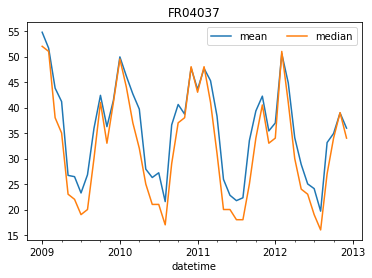

In [16]:
fig, ax = plt.subplots()
data.loc['2009':, 'FR04037'].resample('M').mean().plot(ax=ax, label='mean')
data.loc['2009':, 'FR04037'].resample('M').median().plot(ax=ax, label='median')
ax.legend(ncol=2)
ax.set_title("FR04037");

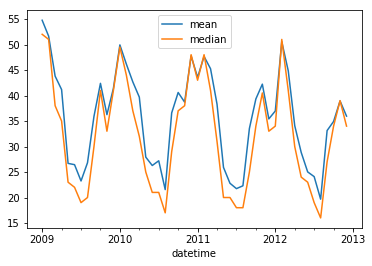

In [17]:
data.loc['2009':, 'FR04037'].resample('M').agg(['mean', 'median']).plot()

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Make a violin plot for January 2011 until August 2011 (check out the documentation to improve the plotting settings)</li>
  <li>Change the y-label to 'NO$_2$ concentration (µg/m³)'</li>
</ul><br>

NOTE: 

When having the data not in a long format but when having different columns for which you want to make violin plots, you can use [seaborn](http://seaborn.pydata.org/examples/index.html).
When using the tidy data, we can use `plotnine`.
</div>

Text(0,0.5,'NO$_2$ concentration (µg/m³)')

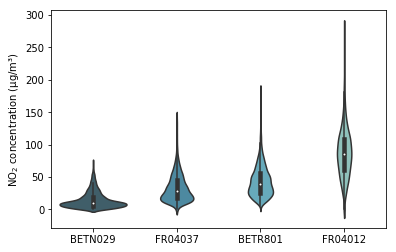

In [18]:
# with seaborn
fig, ax = plt.subplots()
sns.violinplot(data=data['2011-01': '2011-08'], palette="GnBu_d", ax=ax)
ax.set_ylabel("NO$_2$ concentration (µg/m³)")

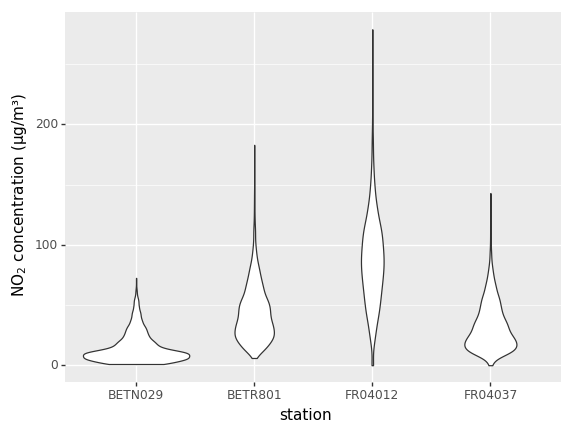

<ggplot: (8773230747768)>

In [19]:
# with plotnine
data_tidy_subset = data_tidy[(data_tidy['datetime'] >= "2011-01") & (data_tidy['datetime'] < "2011-09")]

(pn.ggplot(data_tidy_subset, pn.aes(x='station', y='no2'))
    + pn.geom_violin()
    + pn.ylab("NO$_2$ concentration (µg/m³)"))

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Make a bar plot with pandas of the mean of each of the stations in the year 2012 (check the documentation of Pandas plot to adapt the rotation of the labels) and make sure all bars have the same color.</li>
  <li>Using the matplotlib objects, change the y-label to 'NO$_2$ concentration (µg/m³)</li>
  <li>Add a 'darkorange' horizontal line on the ax for the y-value 40 µg/m³ (command for horizontal line from matplotlib: `axhline`).</li>
  <li>[Place the text](visualization_01_matplotlib.ipynb) 'Yearly limit is 40 µg/m³' just above the 'darkorange' line.</li>
</ul><br>

</div>

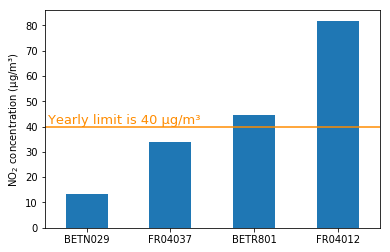

In [20]:
fig, ax = plt.subplots()
data['2012'].mean().plot(kind='bar', ax=ax, rot=0, color='C0')
ax.set_ylabel("NO$_2$ concentration (µg/m³)")
ax.axhline(y=40., color='darkorange')
ax.text(0.01, 0.48, 'Yearly limit is 40 µg/m³',
        horizontalalignment='left', fontsize=13, 
        transform=ax.transAxes, color='darkorange');

<div class="alert alert-success">

<b>EXERCISE:</b> Did the air quality improve over time?

 <ul>
  <li>For the data from 1999 till the end, plot the yearly averages</li>
  <li>For the same period, add the overall mean (all stations together) as an additional line to the graph, use a thicker black line (`linewidt=4` and `linestyle='--'`)</li>
  <li>[OPTIONAL] Add a legend above the ax for all lines</li>
  

</ul>
</div>


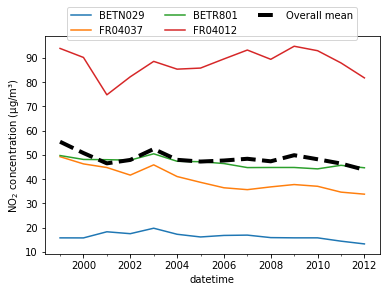

In [21]:
fig, ax = plt.subplots()

data['1999':].resample('A').mean().plot(ax=ax)
data['1999':].mean(axis=1).resample('A').mean().plot(color='k', 
                                            linestyle='--', 
                                            linewidth=4, 
                                            ax=ax, 
                                            label='Overall mean')
ax.legend(loc='center', ncol=3, 
          bbox_to_anchor=(0.5, 1.06))
ax.set_ylabel("NO$_2$ concentration (µg/m³)");

<div class="alert alert-info">

<b>REMEMBER</b>: <br><br>

`resample` is a specifal version of `groupby`. For example, taking annual means with `data.resample('A').mean()` is equivalent to `data.groupby(data.index.year).mean()` (but the result of `resample` still has a DatetimeIndex).<br><br>

Checking the index of the resulting DataFrame when using **groupby** instead of resample: You'll notice that the Index lost the DateTime capabilities:

<code>
> data.groupby(data.index.year).mean().index
</code>

Results in:

<code>
Int64Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
            2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
            2012],
           dtype='int64')$
</code>

<br>
When using **resample**, we keep the DateTime capabilities:

<code>
> data.resample('A').mean().index
</code>
Results in:
<code>
DatetimeIndex(['1999-12-31', '2000-12-31', '2001-12-31', '2002-12-31',
               '2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31',
               '2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31',
               '2011-12-31', '2012-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')
</code>
<br>
But, `groupby` is more flexible and can also do resamples that do not result in a new continuous time series, e.g. by grouping by the hour of the day to get the diurnal cycle.
</div>

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>How does the *typical yearly profile* (typical averages for the different months) look like for the different stations? (add a 'month' column as a first step)</li>

</ul>
</div>

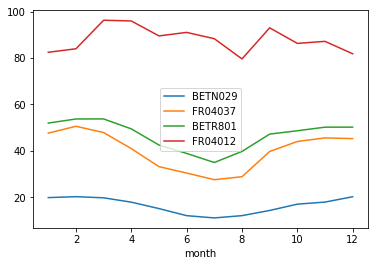

In [22]:
# add a column to the dataframe that indicates the month (integer value of 1 to 12):
data['month'] = data.index.month

# now, we can calculate the mean of each month over the different years:
data.groupby('month').mean()

# plot the typical monthly profile of the different stations:
data.groupby('month').mean().plot()

In [23]:
data = data.drop("month", axis=1)

Note: Technically, we could reshape the result of the groupby operation to a tidy format (we no longer have a real time series), but since we already have the things we want to plot as lines in different columns, doing `.plot` already does what we want.

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Plot the weekly 95% percentiles of the concentration in 'BETR801' and 'BETN029' for 2011</li>

</ul>
</div>

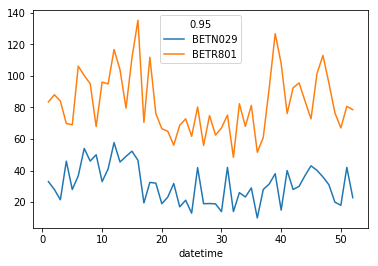

In [24]:
# Groupby wise
df2011 = data['2011']
df2011.groupby(df2011.index.week)[['BETN029', 'BETR801']].quantile(0.95).plot()

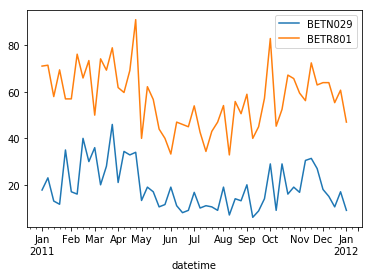

In [25]:
# Resample wise (not possible to use quantile directly on a resample, so you need a lambda function)
# Note the different x-axis labels
df2011[['BETN029', 'BETR801']].resample('W').agg(lambda x: x.quantile(0.75)).plot()

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Plot the typical diurnal profile (typical hourly averages) for the different stations taking into account the whole time period.</li>

</ul>
</div>

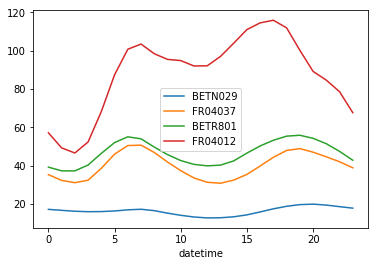

In [26]:
data.groupby(data.index.hour).mean().plot()

<div class="alert alert-success">

<b>EXERCISE</b> <br><br>

What is the difference in the typical diurnal profile between week and weekend days? (and visualise it)<br><br>

Start with only visualizing the different in diurnal profile for the BETR801 station. In a next step, make the same plot for each station.<br><br>

**Hints:**

 <ul>
  <li>Add a column 'weekend' defining if a value of the index is in the weekend (i.e. weekdays 5 and 6) or not</li>
  <li>Add a column 'hour' with the hour of the day for each row.</li>
  <li>You can groupby on multiple items at the same time.</li>

</ul>
</div>

In [27]:
data['weekend'] = data.index.weekday.isin([5, 6])
data['weekend'] = data['weekend'].replace({True: 'weekend', False: 'weekday'})
data['hour'] = data.index.hour

In [28]:
data_weekend = data.groupby(['weekend', 'hour']).mean()
data_weekend.head()

BETN029    FR04037    BETR801    FR04012
weekend hour                                            
weekday 0     17.415094  34.439398  38.693423  52.094663
        1     16.985991  31.585121  37.128589  44.721629
        2     16.530217  30.865143  37.837973  43.518539
        3     16.362120  32.963500  42.446300  51.942135
        4     16.696870  40.780162  50.478893  72.547472

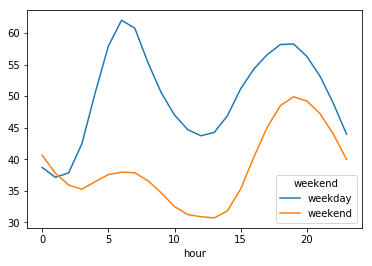

In [29]:
# using unstack and pandas plotting
data_weekend_BETR801 = data_weekend['BETR801'].unstack(level=0)
data_weekend_BETR801.plot()

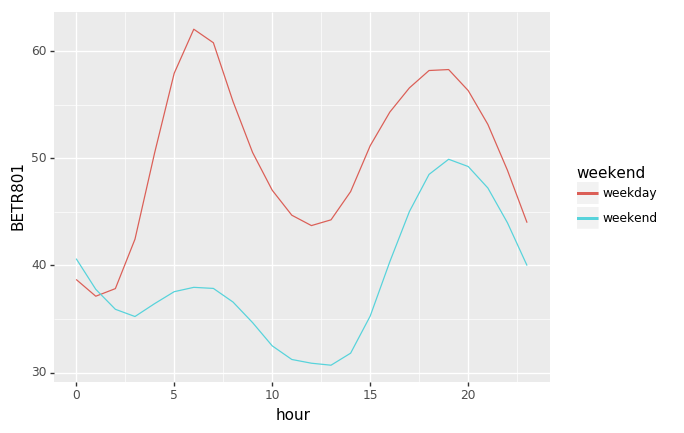

<ggplot: (8773223940195)>

In [30]:
# using a tidy dataset and plotnine
data_weekend_BETR801_tidy = data_weekend['BETR801'].reset_index()

(pn.ggplot(data_weekend_BETR801_tidy,
           pn.aes(x='hour', y='BETR801', color='weekend'))
    + pn.geom_line())

In [31]:
# tidy dataset that still includes all stations

data_weekend_tidy = pd.melt(data_weekend.reset_index(), id_vars=['weekend', 'hour'],
                            var_name='station', value_name='no2')
data_weekend_tidy.head()

,weekend,hour,station,no2
0,weekday,0,BETN029,17.415094
1,weekday,1,BETN029,16.985991
2,weekday,2,BETN029,16.530217
3,weekday,3,BETN029,16.362120
4,weekday,4,BETN029,16.696870


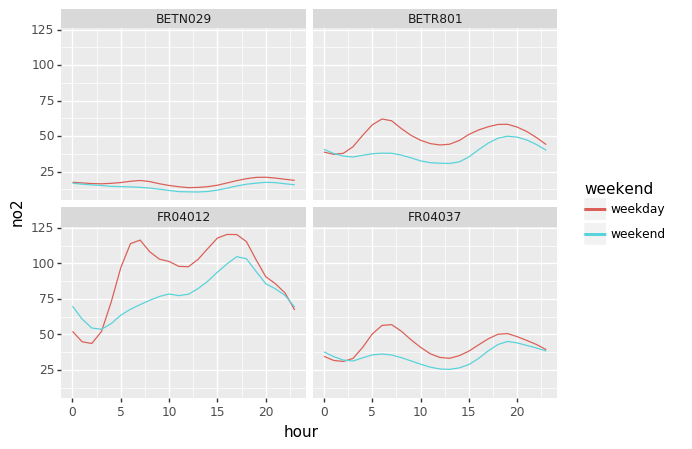

<ggplot: (-9223363263630913697)>

In [32]:
# when still having multiple factors, it becomes useful to convert to tidy dataset and use plotnine
(pn.ggplot(data_weekend_tidy,
           pn.aes(x='hour', y='no2', color='weekend'))
    + pn.geom_line()
    + pn.facet_wrap('station'))

In [33]:
data = data.drop(['hour', 'weekend'], axis=1)

<div class="alert alert-success">

<b>EXERCISE</b>:<br><br>

 <ul>
  <li>Calculate the correlation between the different stations (check in the documentation, google "pandas correlation" or use the magic function `%psearch`)</li>

</ul>
</div>


In [34]:
data[['BETR801', 'BETN029', 'FR04037', 'FR04012']].corr()

,BETR801,BETN029,FR04037,FR04012
BETR801,1.000000,0.472954,0.561676,0.394446
BETN029,0.472954,1.000000,0.401864,0.186997
FR04037,0.561676,0.401864,1.000000,0.433466
FR04012,0.394446,0.186997,0.433466,1.000000


<div class="alert alert-success">

<b>EXERCISE</b>:<br><br>

Count the number of exceedances of hourly values above the European limit 200 µg/m3 for each year and station after 2005. Make a barplot of the counts. Add an horizontal line indicating the maximum number of exceedances (which is 18) allowed per year?<br><br>

**Hints:**

 <ul>
  <li>Create a new DataFrame, called `exceedances`, (with boolean values) indicating if the threshold is exceeded or not</li>
  <li>Remember that the sum of True values can be used to count elements</li>
  <li>Adding a horizontal line can be done with the matplotlib function `ax.axhline`</li>


</ul>
</div>

In [35]:
exceedances = data > 200

In [36]:
# group by year and count exceedances (sum of boolean)
exceedances = exceedances.groupby(exceedances.index.year).sum()

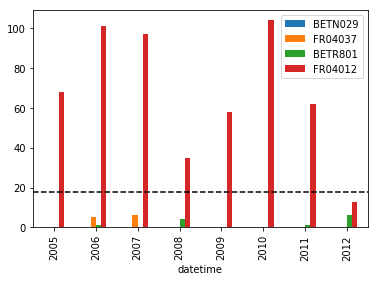

In [37]:
# Make a barplot of the yearly number of exceedances
ax = exceedances.loc[2005:].plot(kind='bar')
ax.axhline(18, color='k', linestyle='--')

# More advanced exercises...

In [38]:
data = alldata['1999':].copy()

<div class="alert alert-success">

<b>EXERCISE</b>: Perform the following actions for the station `'FR04012'` only:

 <ul>
  <li>Remove the rows containing `Nan` or zero values</li>
  <li>Sort the values  of the rows according to the air quality values (low to high values)</li>
  <li>Rescale the values to the range [0-1] and store result as `FR_scaled` (Hint: check [wikipedia](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling))</li>
  <li>Use pandas to plot these values sorted, not taking into account the dates</li>
  <li>Add the station name 'FR04012' as y-label</li>
  <li>[OPTIONAL] Add a vertical line to the plot where the line (hence, the values of variable FR_scaled) reach the value `0.3`. You will need the documentation of `np.searchsorted` and matplotlib's `axvline`</li>
</ul>
</div>

In [39]:
FR_station = data['FR04012'] # select the specific data series
FR_station = FR_station[(FR_station.notnull()) & (FR_station != 0.0)]  # exclude the Nan and zero values

In [40]:
FR_sorted = FR_station.sort_values(ascending=True)
FR_scaled = (FR_sorted - FR_sorted.min())/(FR_sorted.max() - FR_sorted.min())

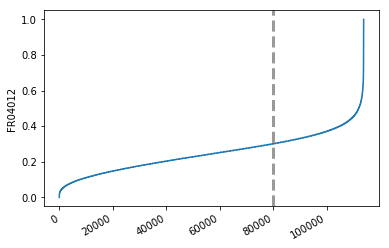

In [41]:
fig, axfr = plt.subplots()
FR_scaled.plot(use_index=False, ax = axfr)  #alternative version: FR_scaled.reset_index(drop=True).plot(use_index=False)  
axfr.set_ylabel('FR04012')
# optional addition, just in case you need this
axfr.axvline(x=FR_scaled.searchsorted(0.3), color='0.6', linestyle='--', linewidth=3)

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Create a Figure with two subplots (axes), for which both ax**i**s are shared</li>
  <li>In the left subplot, plot the histogram (30 bins) of station 'BETN029', only for the year 2009</li>
  <li>In the right subplot, plot the histogram (30 bins) of station 'BETR801', only for the year 2009</li>
  <li>Add the title representing the station name on each of the subplots, you do not want to have a legend</li>
</ul>
</div>

Text(0.5,1,'BETR801')

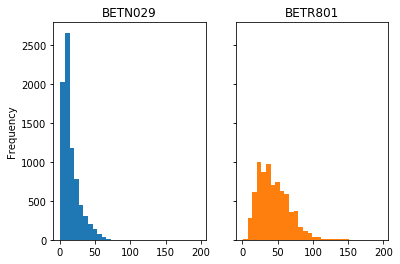

In [42]:
# Mixing an matching matplotlib and Pandas
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               sharex=True, 
                               sharey=True)

data.loc['2009', ['BETN029', 'BETR801']].plot(kind='hist', subplots=True, 
                                              bins=30, legend=False, 
                                              ax=(ax1, ax2))
ax1.set_title('BETN029')
ax2.set_title('BETR801')
# Remark: the width of the bins is calculated over the x data range for both plots together

Text(0.5,1,'BETR801')

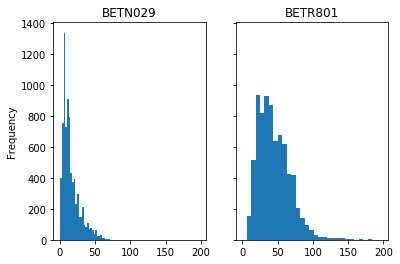

In [43]:
# A more step by step approach (equally valid)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
data.loc['2009', 'BETN029'].plot(kind='hist', bins=30, ax=ax1)
ax1.set_title('BETN029')
data.loc['2009', 'BETR801'].plot(kind='hist', bins=30, ax=ax2)
ax2.set_title('BETR801')
# Remark: the width of the bins is calculated over the x data range for each plot individually

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Make a selection of the original dataset of the data in January 2009, call the resulting variable `subset`</li>
  <li>Add a new column, called 'weekday', to the variable `subset` which defines for each data point the day of the week</li>
  <li>From the `subset` DataFrame, select only Monday (= day 0) and Sunday (=day 6) and remove the others (so, keep this as variable `subset`)</li>
  <li>Change the values of the weekday column in `subset` according to the following mapping: `{0:"Monday", 6:"Sunday"}`</li>
  <li>With plotnine, make a scatter plot of the measurements at 'BETN029' vs 'FR04037', with the color variation based on the weekday. Add a linear regression to this plot.</li>
</ul><br>

**Note**: If you run into the **SettingWithCopyWarning** and do not know what to do, recheck [pandas_03_selecting_data](pandas_03_selecting_data.ipynb)

</div>

In [44]:
subset = data['2009-01'].copy()
subset["weekday"] = subset.index.weekday
subset = subset[subset['weekday'].isin([0, 6])]

In [45]:
subset["weekday"] = subset["weekday"].replace(to_replace={0:"Monday", 6:"Sunday"})

/home/stijn_vanhoey/.pyenv/versions/miniconda3-4.3.11/envs/DS-python-data-analysis/lib/python3.6/site-packages/plotnine/layer.py:450: UserWarning: geom_point : Removed 10 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


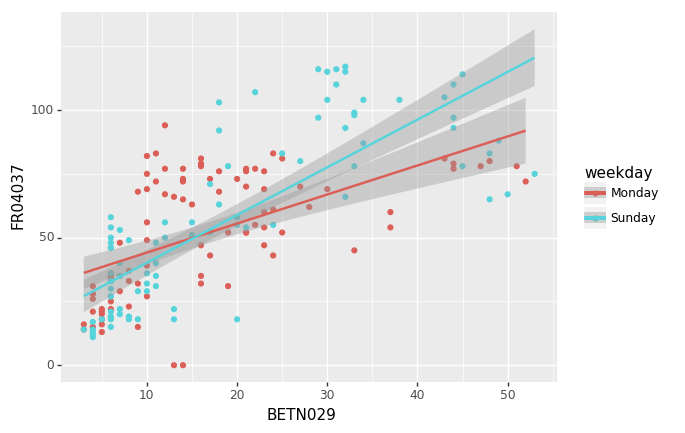

<ggplot: (8773223576605)>

In [46]:
(pn.ggplot(subset,
           pn.aes(x="BETN029", y="FR04037", color="weekday"))
    + pn.geom_point()
    + pn.stat_smooth(method='lm'))

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>The maximum daily, 8 hour mean, should be below 100 µg/m³. What is the number of exceedances of this limit for each year/station?</li><br><br>
  </ul>
 
  
**Tip:**<br>

Have a look at the `rolling` method to perform moving window operations.<br><br>

**Note:**<br>
This is not an actual limit for NO$_2$, but a nice exercise to introduce the `rolling` method. Other pollutans, such as 0$_3$ have actually such kind of limit values based on 8-hour means.

</div>

In [47]:
exceedances = data.rolling(8).mean().resample('D').max() > 100

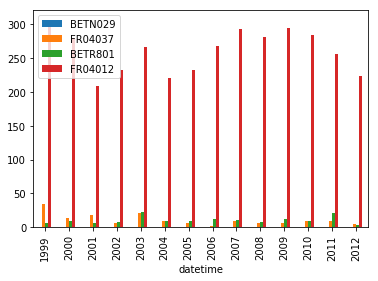

In [48]:
exceedances = exceedances.groupby(exceedances.index.year).sum()
ax = exceedances.plot(kind='bar')

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Visualize the typical week profile for station 'BETR801' as boxplots (where the values in one boxplot are the *daily means* for the different *weeks* for a certain weekday).</li><br><br>
  </ul>
 
  
**Tip:**<br>

The boxplot method of a DataFrame expects the data for the different boxes in different columns. For this, you can either use `pivot_table` or a combination of `groupby` and `unstack`


</div>


In [49]:
data_daily = data.resample('D').mean()

In [50]:
# add a weekday column
data_daily['weekday'] = data_daily.index.weekday
data_daily.head()

,BETN029,FR04037,BETR801,FR04012,weekday
datetime,,,,,
1999-01-01,16.363636,65.166667,35.500000,86.250000,4
1999-01-02,7.727273,38.833333,26.681818,66.916667,5
1999-01-03,8.818182,34.166667,19.636364,65.500000,6
1999-01-04,4.772727,41.041667,35.294118,67.541667,0
1999-01-05,12.954545,59.291667,54.250000,96.416667,1


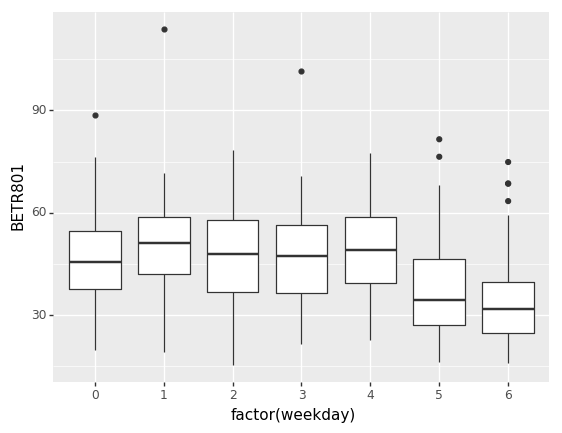

<ggplot: (-9223363263631193242)>

In [51]:
# plotnine
(pn.ggplot(data_daily["2012"],
           pn.aes(x='factor(weekday)', y='BETR801'))
    + pn.geom_boxplot())

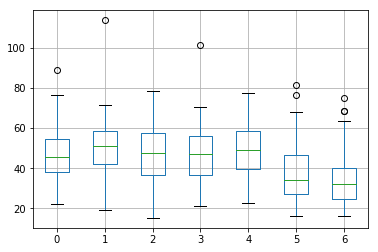

In [52]:
# when using pandas to plot, the different boxplots should be different columns
# therefore, pivot table so that the weekdays are the different columns
data_daily['week'] = data_daily.index.week
data_pivoted = data_daily['2012'].pivot_table(columns='weekday', index='week', values='BETR801')
data_pivoted.head()
data_pivoted.boxplot();

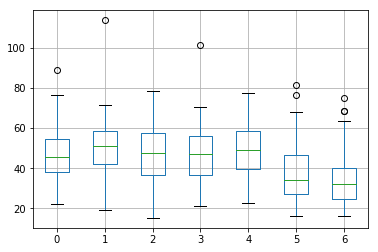

In [53]:
# An alternative method using `groupby` and `unstack`
data_daily['2012'].groupby(['weekday', 'week'])['BETR801'].mean().unstack(level=0).boxplot();